<a href="https://colab.research.google.com/github/JonathanSum/Practice_Deep-Learning/blob/main/ResMLP_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install res-mlp-pytorch

Cite: https://github.com/lucidrains/reformer-pytorch

In [ ]:
import torch
from res_mlp_pytorch import ResMLP

model = ResMLP(
    image_size = 256,
    patch_size = 16,
    dim = 512,
    depth = 12,
    num_classes = 1000
)

img = torch.randn(1, 3, 256, 256)

pred = model(img) # (1, 1000)



In [ ]:
pred.shape

torch.Size([1, 1000])

Rectangular image

In [ ]:
import torch
from res_mlp_pytorch import ResMLP

model = ResMLP(
    image_size = (128, 256), # (128 x 256)
    patch_size = 16,
    dim = 512,
    depth = 12,
    num_classes = 1000
)

img = torch.randn(1, 3, 128, 256)
pred = model(img) # (1, 1000)

Citations

In [ ]:
@misc{touvron2021resmlp,
    title   = {ResMLP: Feedforward networks for image classification with data-efficient training}, 
    author  = {Hugo Touvron and Piotr Bojanowski and Mathilde Caron and Matthieu Cord and Alaaeldin El-Nouby and Edouard Grave and Armand Joulin and Gabriel Synnaeve and Jakob Verbeek and Hervé Jégou},
    year    = {2021},
    eprint  = {2105.03404},
    archivePrefix = {arXiv},
    primaryClass = {cs.CV}
}

In [ ]:
from res_mlp_pytorch.res_mlp_pytorch import ResMLP

In [ ]:
import torch
from torch import nn, einsum
from einops.layers.torch import Rearrange, Reduce

# helpers

def pair(val):
    return (val, val) if not isinstance(val, tuple) else val

# classes

class Affine(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, 1, dim))
        self.b = nn.Parameter(torch.zeros(1, 1, dim))

    def forward(self, x):
        return x * self.g + self.b

class PreAffinePostLayerScale(nn.Module): # https://arxiv.org/abs/2103.17239
    def __init__(self, dim, depth, fn):
        super().__init__()
        if depth <= 18:
            init_eps = 0.1
        elif depth > 18 and depth < = 24:
            init_eps = 1e-5
        else: 
            init_eps = 1e-6
        
        scale = torch.zeros(1, 1, dim).fill_(init_eps)
        self.scale = nn.Parameter(scale)
        self.affine = Affine(dim)
        self.fn = fn
    
    def forward(self, x):
        return self.fn(self.affine(x)) * self.scale + x

def ResMLP(*, image_size, patch_size, dim, depth, num_classes, expansion_factor = 4):
    image_height, image_width = pair(image_size)
    assert (image_height % patch_size) ==0 and (image_width % patch_size) ==0, 'image height and width must be divisible by patch size'
    num_patches = (image_height // patch_size) * (image_width // patch_size)
    wrapper = lambda i, fn:PreAffinePostLayerScale(dim, i + 1, fn)

    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (b w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
        nn.Linear((patch_size ** 2) * 3, dim),
        *[nn.Sequential(
            wrapper(i, nn.Conv1d(num_patches, num_patches 1)),
            wrapper(i, nn.Sequential(
                nn.Linear(dim, dim * expansion_factor),
                nn.GELU(),
                nn.Linear(dim * expansion_factor, dim)
            ))
        ) for i in range(depth)],
        Affine(dim),
        Reduce('b n c -> b c', 'mean'),  #Pooling
        nn.Linear(dim, num_classess)
    )


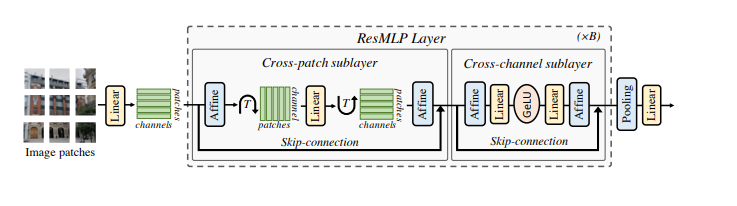